# ToDo

* Upload nilab to git and publish
* Insert link to nilab below
* Check if NoStim_Data.mat is in original data and actually the same data 
* Rename labels $b$ and cognitive-level data $c$. In general, give variables better names

# Learning a NC-MCM model from C. elegans calcium imaging data

This notebook demonstrates how to learn a NC-MCM on calcium data from C. elegans, using the data from Kato et al., 2015 (https://doi.org/10.1016/j.cell.2015.09.034). To run this notebook,

* download the data from https://osf.io/2395t/ and put it into the same directory as this notebook
* download the [nilab](actualink_to_insert_here) toolbox

## Pre-processing

We begin by loading the required packages.

In [1]:
using nilab
using JLD2
using Statistics
using Clustering
using LinearAlgebra
using Gaston
using Gnuplot
using StatsBase
using Hungarian
using Polyhedra
using LazySets
using InteractiveUtils

Next, we define the function to load the calcium imaging data:

In [2]:
function loadce(file, set)

	vars = loadmat(file) 
	ikey = file[1:end-4]
	rawdata = vars[ikey]

	# neuronal data
	x = rawdata["deltaFOverF_bc"][set]
	# x = rawdata["derivs"][set]["traces"]

	# neurons
	neurons = rawdata["NeuronNames"][set]

	# states
	ydict = rawdata["States"][set] 
	K = collect(keys(ydict))
	M = size(x,1)
	yfull = zeros(M, length(K))

	for (i, k) in enumerate(K)

		yfull[:, i] = ydict[k]

	end

	y = [argmax(yfull[i,:]) for i in 1:M]

	return x, y, K, neurons

end

loadce (generic function with 1 method)

The above function loads and returns the calcium data ($x$), the behavioral label for each sample ($y$), the names of the labels ($K$) and the names of the recorded neurons ($neurons$).

We use this function to load the data without stimulation for all five worms in the data set:

In [3]:
xall = []
yall = []
statesall = []
neuronsall = []

for nset = 1:5

	x, y, states, neurons = loadce("NoStim_Data.mat", nset)

	push!(xall, x)
	push!(yall, y)
	push!(statesall, states)
	push!(neuronsall, neurons)

end

# hack: this neuron's name is of type Any{String}, reformatting
neuronsall[4][end] = neuronsall[4][end][1];


Because some of the neurons are used as proxies for the behavioral labels, we exclude these neurons from the data if they have been recorded, forming a new reduced variable $xredall$:

In [4]:
xredall = []

# identify and exclude neurons used to determine behaviour
for cur_data_set = 1:5

	# select data set
	x = xall[cur_data_set]
	y = yall[cur_data_set]

	# identify and exclude neurons used to determine state
	behav_neurons = ["AVAL", "AVAR", "SMDDR", "SMDDL", "SMDVR", "SMDVL", "RIBR", "RIBL"]
	neuron_names = 	neuronsall[cur_data_set]

	delx = []

	for neuron in behav_neurons

		idel = findall( neuron .== neuron_names )

		if isempty(idel)

			println("Neuron ", neuron, " not found in data set ", cur_data_set)

		else

			push!(delx, idel[1][2])

		end

	end

	xdelmask = trues(size(x)[2])
	xdelmask[delx] .= false
	xred = x[:, xdelmask]
	push!(xredall, xred)

end

Neuron SMDDL not found in data set 1
Neuron RIBR not found in data set 1
Neuron SMDVL not found in data set 4


## Learning the NC-MCM

We first learn one-vs-one logistic regression classifiers to predict the behavioral labels from the neuronal states (running this cell takes some time):

In [21]:
models = []

for cur_data_set = 1:5

    # select data set
    xred = xredall[cur_data_set]
    y = yall[cur_data_set]

    # predict
    base_model = logreg()
    model = multiclasstrain( base_model, xred, y)
    ypred = multiclasspredict( model, xred)
    acc = mean(ypred .== y)

    push!(models, model)
    println(acc)

end

LoadError: InterruptException:

In [5]:
# load pre-trained models
@load "results_after_logreg_solver_update" models

1-element Array{Symbol,1}:
 :models

Having trained the neuro-behavioral models, we estimate the probabilities of all behaviors for each neuronal sample:

In [6]:
ypall = []
Wall = []

for nset = 1:5

	# select data set
	model = models[nset]
	xred = xredall[nset]

	# get probabilities and weights
	M, N = size(xred)
	K = length(model.models)
	yp = zeros(M, K)
	W = zeros(N, K)

	for k = 1:length(model.models)

		yp[:,k] = predictprob(model.models[k], xred)
		W[:,k] = model.models[k].weights

	end

	push!(ypall, yp)
	push!(Wall, W)

end

Next, we cluster the probabilities to identify partitions in the neuronal space with (approximately) constant probabilities over the behaviors with k-means, with the number of clusters ranging from 1 to 20 and 100 repetitions each, and test each resulting cognitive-level model for Markovianity:

In [25]:
nrep = 100
max_clusters = 20
p_markov = zeros(max_clusters, nrep, 5)
xcall = []

for nset = 1:5

    M = size(ypall[nset])[1]
    xc = zeros(M, max_clusters, nrep)

    for reps = 1:nrep

        println("Set ", nset, " repetition ", reps)

        for nrclusters = 1:20

            clusters = kmeans( ypall[nset]', nrclusters)
            xctmp = assignments(clusters)

            p, _ = markovian(xctmp)

            p_markov[nrclusters, reps, nset] = p
            xc[:, nrclusters, reps] = xctmp

        end

    end

    push!(xcall, xc)

end

Set 1 repetition 1
Set 1 repetition 2
Set 2 repetition 1
Set 2 repetition 2
Set 3 repetition 1
Set 3 repetition 2
Set 4 repetition 1
Set 4 repetition 2
Set 5 repetition 1
Set 5 repetition 2


In [7]:
# load pre-trained models
@load "results_after_logreg_solver_update" p_markov xcall

2-element Array{Symbol,1}:
 :p_markov
 :xcall

We then inspect the evidence against Markovianity for each number of clusters and pick the cognitive-level model with the least evidence against Markovianity (highest $p$-value, averaged across all repetitions):

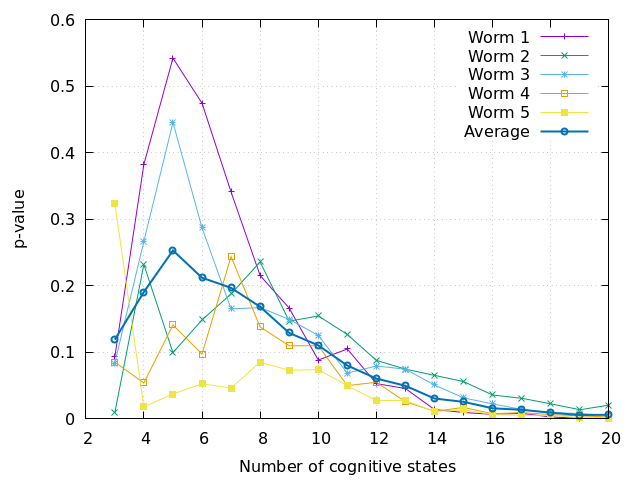

In [14]:
pm = dropdims(mean(p_markov, dims = 2), dims = 2)
nr_cog_states = argmax(mean(pm[3:end,:], dims = 2))[1] + 2 # optimal number of cognitive states across worms according to Markovianity
nr_cog_states_per_worm = [i[1] for i in argmax(pm[3:end,:], dims = 1)] .+ 2 # optimal number of cognitive states per worm according to Markovianity

# plot
@gp 3:20 pm[3:end, 1] "w lp tit 'Worm 1'"
@gp :- 3:20 pm[3:end, 2] "w lp tit 'Worm 2'"
@gp :- 3:20 pm[3:end, 3] "w lp tit 'Worm 3'"
@gp :- 3:20 pm[3:end, 4] "w lp tit 'Worm 4'"
@gp :- 3:20 pm[3:end, 5] "w lp tit 'Worm 5'"
@gp :- 3:20 mean(pm[3:end, :], dims = 2) "w lp tit 'Average' lw 2"
@gp :- "set grid"
@gp :- "set xlabel 'Number of cognitive states'"
@gp :- "set ylabel 'p-value'"


For each worm and optimal number of cognitive states, we map the neuronal states to their cognitive states, taking a majority vote over all cognitive models resulting from the k-means iterations.

In [ ]:
cog_states = [] # cognitive state trajectories
cog_p_markov = [] # p-values for Markovianity test
cog_T = [] # cognitive state transition matrices

for nset = 1:5 # counter over worms

	alpha = 0.2 # lower limit on p-value for accepting H0: first-order Markov process
	markovian_cluster_assignemnts = findall(p_markov[nr_cog_states,:,nset] .>= alpha)
	K = length(markovian_cluster_assignemnts)

	c = zeros(size(xcall[nset])[1], K)
	c[:,1] = xcall[nset][:,nr_cog_states, markovian_cluster_assignemnts[1]] # reference cluster

	for k = 2:K

		ccomp = xcall[nset][:,nr_cog_states,markovian_cluster_assignemnts[k]]
		cmatched = similar(ccomp)

		C = zeros(nr_cog_states, nr_cog_states)

		for i = 1:nr_cog_states

			for j = 1:nr_cog_states

				C[i,j] = mean((c[:,1] .== i) .== (ccomp .== j))

			end

		end

		assignment, cost = hungarian(1 .- C)

		for (i, j) in enumerate(assignment)

			ic = findall(ccomp .== j)
			cmatched[ic] .= i

		end

		c[:,k] = cmatched

	end

	# majority vote over all repetitions of kmeans clustering
	cmaj = [StatsBase.mode(c[i,:]) for i in 1:size(c)[1]]
	p_cmaj, T_cmaj = markovian(cmaj)

	# store results
	push!(cog_states, cmaj)
	push!(cog_p_markov, p_cmaj)
	push!(cog_T, T_cmaj)

end

# link cognitive to behavioural states

CBT = []

for nset = 1:5

	CST = zeros(nr_cog_states, length(unique(yall[nset])))
	M = length(cog_states[nset])
	ic = convert.(Int64, cog_states[nset])

	for m in 1:M

		CST[ic[m], yall[nset][m]] += 1

	end

	CST ./= M

	push!(CBT, CST)

end


## Plot results for individual worms

In [4]:
iworm = 1; # pick data set

### Relation of cognitive states to behaviours

In [ ]:
@gp  palette(:coolwarm)
@gp :- "set label front rotate 'P(B|C)' at screen 0.97, graph 0.35"

@gp :- A "with image pixels"
@gp :- "set autoscale fix"
@gp :- "set cbrange [0:1]"
@gp :- "set ylabel 'Worm'"
@gp :- "set xlabel 'Behavioural state (B)'"
@gp :- "set xtics ('rev2' 0, 'rev1' 1, 'slow' 2, 'vt' 3, 'nostate' 4, 'revsus' 5, 'fwd' 6, 'dt' 7)"
@gp :- "set ytics ('C1, W1' 0, 'C1, W2' 1, '3' 2, '4' 3, '5' 4)"
@gp :- "set title 'Cognitive state C = $k'"


### Cognitive state transition matrix

### Cognitive state dynamics

### Cognition, behaviour and neuronal patterns

## Plot group-level results

### Correlation of behaviours across cognitive states

We then map cognitive states across data sets and analyze transition as well as state trajectories:

In [9]:
# nr_cog_states = 8 # overwrite result fo previous section to exploratative analysis

cog_states = []
cog_p_markov = []
cog_T = []

for nset = 1:5

	alpha = 0.2 # lower limit on p-value for accepting H0: first-order Markov process
	markovian_cluster_assignemnts = findall(p_markov[nr_cog_states,:,nset] .>= alpha)
	K = length(markovian_cluster_assignemnts)

	c = zeros(size(xcall[nset])[1], K)
	c[:,1] = xcall[nset][:,nr_cog_states, markovian_cluster_assignemnts[1]] # reference cluster

	for k = 2:K

		ccomp = xcall[nset][:,nr_cog_states,markovian_cluster_assignemnts[k]]
		cmatched = similar(ccomp)

		C = zeros(nr_cog_states, nr_cog_states)

		for i = 1:nr_cog_states

			for j = 1:nr_cog_states

				C[i,j] = mean((c[:,1] .== i) .== (ccomp .== j))

			end

		end

		assignment, cost = hungarian(1 .- C)

		for (i, j) in enumerate(assignment)

			ic = findall(ccomp .== j)
			cmatched[ic] .= i

		end

		c[:,k] = cmatched

	end

	# majority vote over all repetitions of kmeans clustering
	cmaj = [StatsBase.mode(c[i,:]) for i in 1:size(c)[1]]
	p_cmaj, T_cmaj = markovian(cmaj)

	# store results
	push!(cog_states, cmaj)
	push!(cog_p_markov, p_cmaj)
	push!(cog_T, T_cmaj)

end

# link cognitive to behavioural states

CBT = []

for nset = 1:5

	CST = zeros(nr_cog_states, length(unique(yall[nset])))
	M = length(cog_states[nset])
	ic = convert.(Int64, cog_states[nset])

	for m in 1:M

		CST[ic[m], yall[nset][m]] += 1

	end

	CST ./= M

	push!(CBT, CST)

end

# Map cognitive states across worms

ccb1 = CBT[1] ./ sum(CBT[1], dims = 2) # reference worm

for k in 2:5

	ccb2 = CBT[k] ./ sum(CBT[k], dims = 2)

	C = zeros(nr_cog_states, nr_cog_states)

	for i = 1:nr_cog_states

		for j = 1:nr_cog_states

			C[i,j] = sum( (ccb1[i,:] - ccb2[j,:]).^2 )

		end

	end

	ass, cost = hungarian(C')

	cur_cog_states = convert.(Int64, cog_states[k])

	for n in 1:length(cog_states[k])

		cog_states[k][n] = ass[cur_cog_states[n]]

	end

end

# Update cognitive state transition matrices

for nset = 1:5

	p_c2, T_c2 = markovian(cog_states[nset])
	cog_T[nset] = T_c2

end

# relink updated cognitive states to behaviours (same code as above)

CBT = []

for nset = 1:5

	CST = zeros(nr_cog_states, length(unique(yall[nset])))
	M = length(cog_states[nset])
	ic = convert.(Int64, cog_states[nset])

	for m in 1:M

		CST[ic[m], yall[nset][m]] += 1

	end

	CST ./= M

	push!(CBT, CST)

end

Plot the group results:

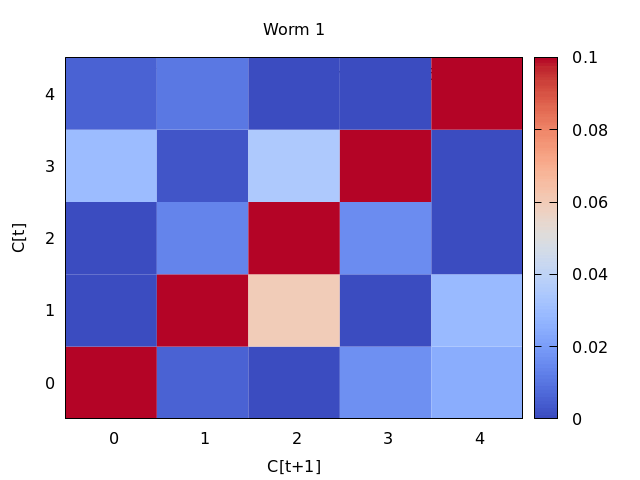

In [20]:
#%% plot cognitive state transition matrices
# @gp "set term qt size 600, 800"
# @gp "set multiplot layout 5,1"
@gp palette(:coolwarm)
# @gp :- "set label front rotate 'P(C[t+1]|C[t])' at screen 0.975, graph 0.1"

k = 1
# for k = 1:5 # one plot per worm

	@gp :- k cog_T[k] "with image pixels"
	@gp :- k "set autoscale fix"
	@gp :- k "set cbrange [0:0.1]"
	@gp :- k "set ylabel 'C[t]"
	@gp :- k "set xlabel 'C[t+1]"
	# @gp :- k "set ytics ('1' 0, '2' 1, '3' 2, '4' 3, '5' 4)"
	# @gp :- k "set xtics ('1' 0, '2' 1, '3' 2, '4' 3, '5' 4)"
	@gp :- k "set title 'Worm $k'"

# end


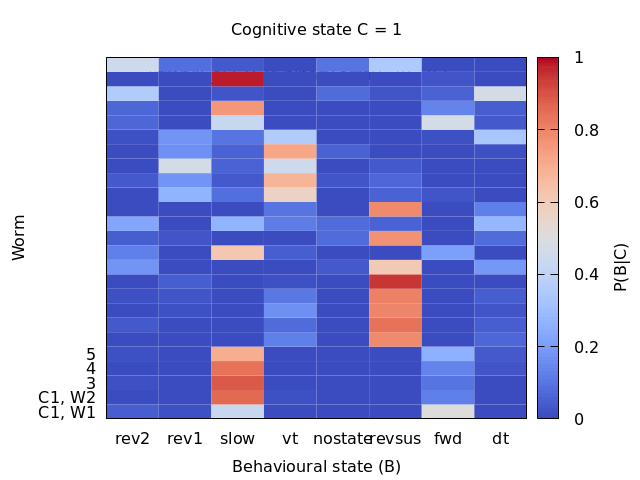

In [61]:
#%% plot relation of cognitive state to behaviour across worms
cbt_plot = zeros(5, 8, nr_cog_states)

for i in 1:5 # worms
	for j in 1:nr_cog_states # states
		cbt_plot[i,:,j] = CBT[i][j,:] ./ sum(CBT[i][j,:])
	end
end

# @gp "set term qt size 600, 800"
# @gp "set multiplot layout 5, 1"
@gp  palette(:coolwarm)
@gp :- "set label front rotate 'P(B|C)' at screen 0.97, graph 0.35"

# for k in 1:nr_cog_states

# k = 1

A = reshape(permutedims( cbt_plot[:,:,:], (1, 3, 2)), (25, 8))

	@gp :- A "with image pixels"
	@gp :- "set autoscale fix"
	@gp :- "set cbrange [0:1]"
	@gp :- "set ylabel 'Worm'"
	@gp :- "set xlabel 'Behavioural state (B)'"
	@gp :- "set xtics ('rev2' 0, 'rev1' 1, 'slow' 2, 'vt' 3, 'nostate' 4, 'revsus' 5, 'fwd' 6, 'dt' 7)"
	@gp :- "set ytics ('C1, W1' 0, 'C1, W2' 1, '3' 2, '4' 3, '5' 4)"
	@gp :- "set title 'Cognitive state C = $k'"

# end


In [62]:
q = ('C1, W1' 0, 'C1, W2' 1, '3' 2, '4' 3, '5' 4)


LoadError: syntax: character literal contains multiple characters

In [28]:
#%% plot cognitive state transition matrices
@gp "set term qt size 600, 800"
@gp "set multiplot layout 5,1"
@gp :- palette(:coolwarm)
@gp :- "set label front rotate 'P(C[t+1]|C[t])' at screen 0.975, graph 0.1"

for k = 1:5 # one plot per worm

	@gp :- k cog_T[k] "with image"
	@gp :- k "set autoscale fix"
	@gp :- k "set cbrange [0:0.1]"
	@gp :- k "set ylabel 'C[t]"
	@gp :- k "set xlabel 'C[t+1]"
	# @gp :- k "set ytics ('1' 0, '2' 1, '3' 2, '4' 3, '5' 4)"
	# @gp :- k "set xtics ('1' 0, '2' 1, '3' 2, '4' 3, '5' 4)"
	@gp :- k "set title 'Worm $k'"

end

#%% plot relation of cognitive state to behaviour across worms
cbt_plot = zeros(5, 8, nr_cog_states)

for i in 1:5 # worms
	for j in 1:nr_cog_states # states
		cbt_plot[i,:,j] = CBT[i][j,:] ./ sum(CBT[i][j,:])
	end
end

@gp "set term qt size 600, 800"
@gp "set multiplot layout 5, 1"
@gp :- palette(:coolwarm)
@gp :- "set label front rotate 'P(B|C)' at screen 0.97, graph 0.35"

for k in 1:nr_cog_states

	@gp :- k cbt_plot[:,:,k] "with image"
	@gp :- "set autoscale fix"
	@gp :- "set cbrange [0:1]"
	@gp :- "set ylabel 'Worm'"
	@gp :- "set xlabel 'Behavioural state (B)'"
	@gp :- "set xtics ('rev2' 0, 'rev1' 1, 'slow' 2, 'vt' 3, 'nostate' 4, 'revsus' 5, 'fwd' 6, 'dt' 7)"
	@gp :- "set ytics ('1' 0, '2' 1, '3' 2, '4' 3, '5' 4)"
	@gp :- "set title 'Cognitive state C = $k'"

end


We then plot the neuronal states along the behavioral and the cognitive states:

In [24]:
nset = 1 # pick worm 

# Plot neuronal traces with cognitive and behavioural states

xplot = deepcopy(xall[nset])
xplot = xplot .- minimum(xplot) # normalize for plotting
xplot = (xplot ./ maximum(xplot)) .* 8
zplot = cat(xplot, repeat(yall[nset], outer = (1,5)), repeat(cog_states[nset], outer = (1,5)), dims = 2)

xindices = 1:(size(xplot, 2))
xindices = cat(xindices, 112, 117, dims = 1)
xlabels = dropdims(cat(string.(neuronsall[nset]), "B", "C", dims = 2), dims = 1)

@gp  palette(:coolwarm)
@gp :- zplot "with image" # add 'pixels' to avoid interpolation
@gp :- "set autoscale fix"
@gp :- "set xtics 'xlabels'"


# imagesc(zplot, Axes(
#     ylabel = "'frame'",
#     xlabel = "'neurons / behaviours / cognitive states'",
#     palette = :coolwarm,
#     autoscale = "fix",
#     xtics = (xindices, xlabels),
#     axesconf = """ set xtics rotate 45"""
# 	))


┌ Error: 
│ 
│ gnuplot> set xtics 'xlabels'
│                             ^
│          line 228: increment must be positive
└ @ Gnuplot /home/moritzgw/.julia/packages/Gnuplot/7y0ez/src/Gnuplot.jl:897


LoadError: Gnuplot error: ["increment must be positive"]

In [25]:
InteractiveUtils.varinfo()

| name                   |        size | summary                       |
|:---------------------- | -----------:|:----------------------------- |
| Base                   |             | Module                        |
| CBT                    |   1.836 KiB | 5-element Array{Any,1}        |
| Core                   |             | Module                        |
| Main                   |             | Module                        |
| Wall                   | 129.773 KiB | 5-element Array{Any,1}        |
| cbt_plot               |   1.609 KiB | 5×8×5 Array{Float64,3}        |
| ccb1                   |   360 bytes | 5×8 Array{Float64,2}          |
| cog_T                  |   1.250 KiB | 5-element Array{Any,1}        |
| cog_p_markov           |   120 bytes | 5-element Array{Any,1}        |
| cog_states             | 122.633 KiB | 5-element Array{Any,1}        |
| is_authenticating      |      1 byte | Base.RefValue{Bool}           |
| k                      |     8 bytes | Int64                         |
| loadce                 |     0 bytes | typeof(loadce)                |
| models                 | 168.821 KiB | 5-element Array{Any,1}        |
| neuronsall             |  11.417 KiB | 5-element Array{Any,1}        |
| nr_cog_states          |     8 bytes | Int64                         |
| nr_cog_states_per_worm |    80 bytes | 1×5 Array{Int64,2}            |
| nset                   |     8 bytes | Int64                         |
| p_markov               |  78.172 KiB | 20×100×5 Array{Float64,3}     |
| pm                     |   840 bytes | 20×5 Array{Float64,2}         |
| register_auth_handler  |     0 bytes | typeof(register_auth_handler) |
| statesall              |   1.055 KiB | 5-element Array{Any,1}        |
| xall                   |  15.025 MiB | 5-element Array{Any,1}        |
| xcall                  | 238.983 MiB | 5-element Array{Any,1}        |
| xindices               |   928 bytes | 111-element Array{Int64,1}    |
| xlabels                |   2.065 KiB | 111-element Array{String,1}   |
| xplot                  |   2.609 MiB | 3137×109 Array{Float64,2}     |
| xredall                |  14.142 MiB | 5-element Array{Any,1}        |
| yall                   | 122.633 KiB | 5-element Array{Any,1}        |
| ypall                  |   3.346 MiB | 5-element Array{Any,1}        |
| zplot                  |   2.848 MiB | 3137×119 Array{Float64,2}     |
